In [111]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [112]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [113]:
training_set.image_shape

(224, 224, 3)

In [114]:
val_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [115]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


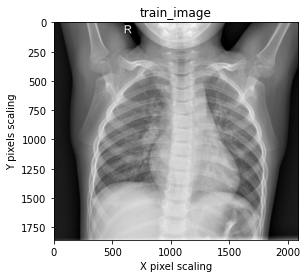

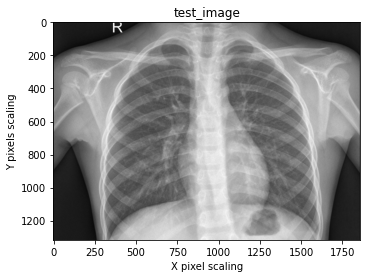

In [116]:
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
 
plt.title("train_image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

 
train_image = image.load_img('train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(train_image)
plt.show()

plt.title("test_image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
test_image = image.load_img('test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(test_image)
plt.show()


In [117]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, \
            Concatenate, AvgPool2D, Dropout, Flatten, Dense

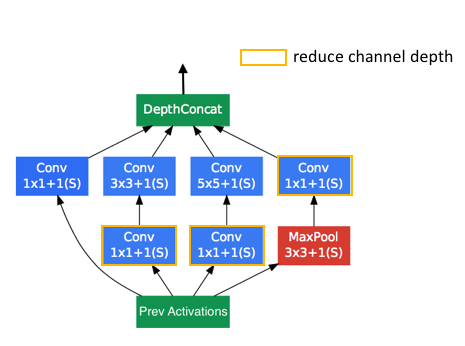

In [118]:
def inception_block(x,filters):

    #  1x1 conv
    t1 = Conv2D(filters[0], kernel_size=1, activation='relu')(x)

    #  1x1 conv -> 3x3 conv 
    t2 = Conv2D(filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    #  1x1 conv -> 5x5 conv 
    t3 = Conv2D(filters[3], kernel_size=1, activation='relu')(x)
    t3 = Conv2D(filters[4], kernel_size=5, padding='same', activation='relu')(t3)

    #  maxpool -> 1x1 conv 
    t4 = MaxPool2D( pool_size=3, strides=1,padding="same")(x)
    t4 = Conv2D(filters[5], kernel_size=1, activation='relu')(t4)
    
    #Dept-Concatenate
    output = Concatenate()([t1,t2,t3,t4])
    
    return output

In [119]:
from tensorflow.keras import Model

input = Input([224,224,3])
output = inception_block(input,[1,1,1,1,1,1])

model = Model(input,output)

In [120]:
from tensorflow.keras.utils import plot_model

plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


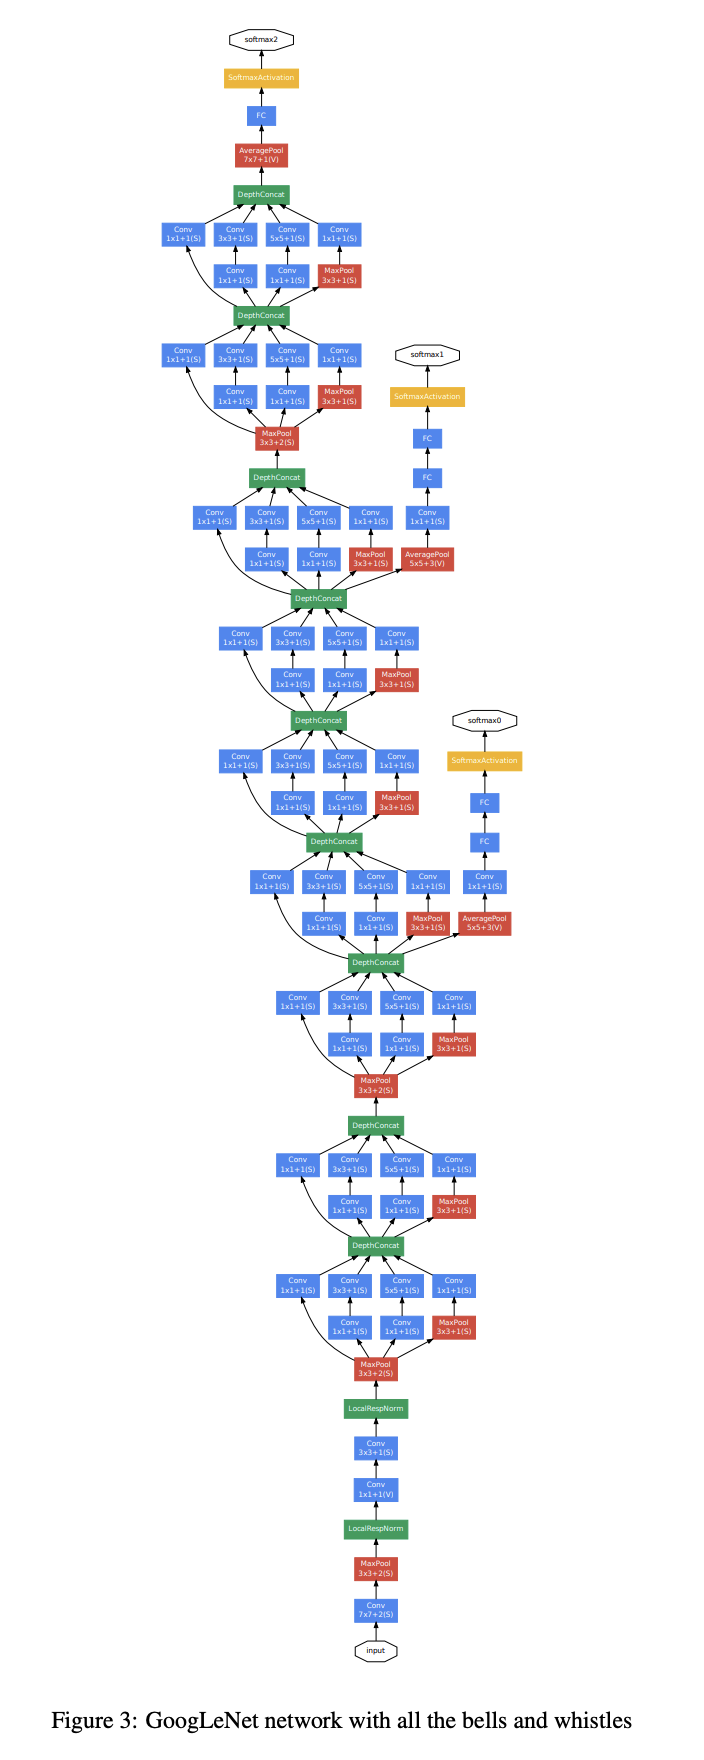

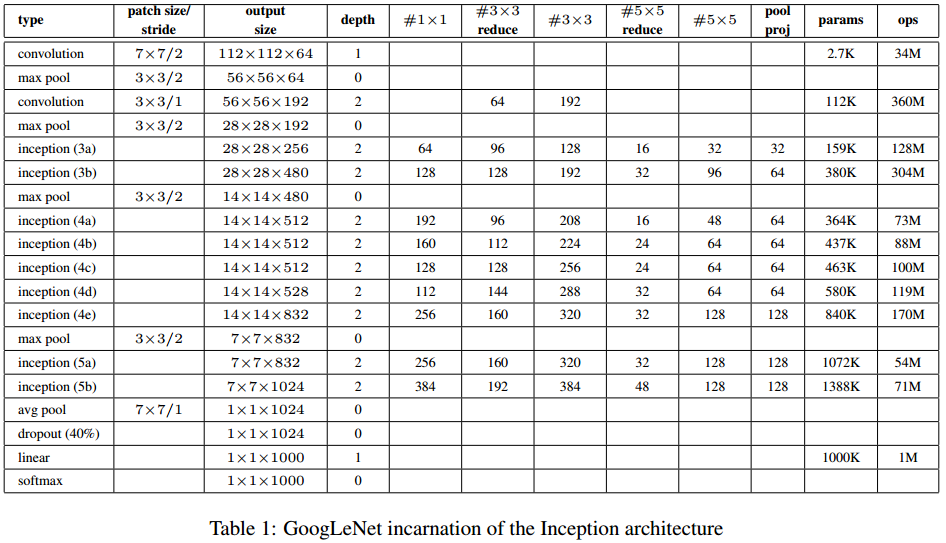

In [121]:
#Row - 1,2
input = Input(shape = [224,224,3])
x = Conv2D(filters=64, kernel_size=7, strides=2,padding="same", activation='relu')(input)
x = MaxPool2D(pool_size=3,strides=2,padding="same")(x)

In [122]:
#Row - 3,4
x = Conv2D(filters = 64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters = 192, kernel_size=3, activation='relu')(x)
x = MaxPool2D(pool_size=3,strides=2,padding="same")(x)

In [123]:
#Row - 5,6,7
x = inception_block(x,[64,96,128,16,32,32])
x = inception_block(x,[128,128,192,32,96,64])
x = MaxPool2D(pool_size=3,strides=2,padding="same")(x)

In [124]:
#Row - 8,9,10,11,12,13
x = inception_block(x,[192,96,208,16,48,64])
x = inception_block(x,[160,112,224,24,64,64])
x = inception_block(x,[128,128,256,24,64,64])
x = inception_block(x,[112,144,288,32,64,64])
x = inception_block(x,[256,160,320,32,128,128])
x = MaxPool2D(pool_size=3,strides=2,padding="same")(x)

In [125]:
#Row - 8,9,10,11,12,13
x = inception_block(x,[256,160,320,32,128,128])
x = inception_block(x,[384,192,384,48,128,128])
x = AvgPool2D(pool_size=7, strides=1)(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
output = Dense(units=1, activation='sigmoid')(x)

In [126]:
from tensorflow.keras import Model

model = Model(inputs = input, outputs = output)

In [127]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_444 (Conv2D)            (None, 112, 112, 64  9472        ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_96 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_444[0][0]']             
 )                                                                                         

In [128]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(x = training_set, validation_data = validation_set, epochs = 25)